In [1]:
# Install required packages
!pip install gdown tqdm matplotlib pillow einops

In [2]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
import math
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import zipfile
import shutil
import glob
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


In [3]:

# -------------------------
# Multi-Kernel Positional Embedding Module
# -------------------------
class MultiKernelPositionalEmbedding(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(MultiKernelPositionalEmbedding, self).__init__()
        self.mid_channels = max(8, in_channels // reduction)
        
        # Multiple kernels of different sizes to capture multi-scale spatial information
        self.conv3x3 = nn.Conv2d(in_channels, self.mid_channels, kernel_size=3, padding=1)
        self.conv5x5 = nn.Conv2d(in_channels, self.mid_channels, kernel_size=5, padding=2)
        self.conv7x7 = nn.Conv2d(in_channels, self.mid_channels, kernel_size=7, padding=3)
        
        # Position-sensitive attention
        self.position_attention = nn.Sequential(
            nn.Conv2d(self.mid_channels * 3, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Extract multi-scale features
        feat_3x3 = self.conv3x3(x)
        feat_5x5 = self.conv5x5(x)
        feat_7x7 = self.conv7x7(x)
        
        # Concatenate multi-scale features
        multi_scale_feat = torch.cat([feat_3x3, feat_5x5, feat_7x7], dim=1)
        
        # Generate position-sensitive attention map
        attention_map = self.position_attention(multi_scale_feat)
        
        # Apply attention to input features
        enhanced = x * attention_map
        
        return enhanced

# -------------------------
# Double Convolution with MKPE
# -------------------------
class DoubleConvWithMKPE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels == out_channels
        
        # Double convolution
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Multi-Kernel Positional Embedding
        self.mkpe = MultiKernelPositionalEmbedding(out_channels)
        
        # Optional projection for residual connection
        if not self.same_channels:
            self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            
    def forward(self, x):
        identity = x if self.same_channels else self.project(x)
        
        # Double convolution
        x = self.double_conv(x)
        
        # Apply Multi-Kernel Positional Embedding
        x = self.mkpe(x)
        
        # Residual connection
        x = x + identity
        
        return x

# -------------------------
# Dataset Download and Setup - Adapted for Kaggle
# -------------------------
def download_and_setup_dataset(force_download=False):
    """Download and properly set up Kvasir-SEG dataset"""
    base_path = '/kaggle/working/datasets'
    kvasir_path = os.path.join(base_path, 'kvasir-seg')
    
    # First check if dataset exists in Kaggle input directory
    kaggle_input_path = '/kaggle/input'
    for dirname, _, _ in os.walk(kaggle_input_path):
        if 'kvasir-seg' in dirname.lower() and os.path.exists(os.path.join(dirname, 'images')):
            print(f"Found Kvasir-SEG dataset at {dirname}")
            return dirname

    # Make sure base directory exists
    os.makedirs(base_path, exist_ok=True)

    # Check if dataset already exists in the expected directory structure
    if os.path.exists(os.path.join(kvasir_path, 'images')) and \
       os.path.exists(os.path.join(kvasir_path, 'masks')) and \
       len(os.listdir(os.path.join(kvasir_path, 'images'))) > 0 and \
       not force_download:
        print("Kvasir-SEG dataset already exists.")
        return kvasir_path

    # Direct URL to the zip file
    dataset_url = "https://datasets.simula.no/downloads/kvasir-seg.zip"
    zip_path = os.path.join(base_path, 'kvasir-seg.zip')

    # Download the dataset
    print("Downloading Kvasir-SEG dataset...")
    try:
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(zip_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return None

    print(f"Download completed, file saved to {zip_path}")

    # Extract the dataset
    print("Extracting dataset...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_path)
        print("Extraction completed.")
    except Exception as e:
        print(f"Error extracting dataset: {e}")
        return None

    # Check the structure of extracted files
    extracted_files = glob.glob(os.path.join(base_path, "**"), recursive=True)
    print("Extracted file structure:")
    for file in extracted_files[:10]:  # Show only first 10 files
        print(f"  {file}")
    if len(extracted_files) > 10:
        print(f"  ... and {len(extracted_files)-10} more files")

    # Locate the images and masks directories
    image_dirs = glob.glob(os.path.join(base_path, "**/images"), recursive=True)
    mask_dirs = glob.glob(os.path.join(base_path, "**/masks"), recursive=True)

    print(f"Found image directories: {image_dirs}")
    print(f"Found mask directories: {mask_dirs}")

    # Ensure proper directory structure
    os.makedirs(os.path.join(kvasir_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(kvasir_path, 'masks'), exist_ok=True)

    # Copy files to the expected location if needed
    if image_dirs and mask_dirs:
        src_image_dir = image_dirs[0]
        src_mask_dir = mask_dirs[0]

        if src_image_dir != os.path.join(kvasir_path, 'images'):
            print(f"Moving images from {src_image_dir} to {os.path.join(kvasir_path, 'images')}")
            for img_file in os.listdir(src_image_dir):
                shutil.copy(
                    os.path.join(src_image_dir, img_file),
                    os.path.join(kvasir_path, 'images', img_file)
                )

        if src_mask_dir != os.path.join(kvasir_path, 'masks'):
            print(f"Moving masks from {src_mask_dir} to {os.path.join(kvasir_path, 'masks')}")
            for mask_file in os.listdir(src_mask_dir):
                shutil.copy(
                    os.path.join(src_mask_dir, mask_file),
                    os.path.join(kvasir_path, 'masks', mask_file)
                )

    # Clean up
    try:
        os.remove(zip_path)
        print("Removed zip file.")
    except:
        print("Could not remove zip file.")

    # Verify the dataset is now properly set up
    if os.path.exists(os.path.join(kvasir_path, 'images')) and \
       os.path.exists(os.path.join(kvasir_path, 'masks')) and \
       len(os.listdir(os.path.join(kvasir_path, 'images'))) > 0:
        print("Dataset setup completed successfully.")
        print(f"Found {len(os.listdir(os.path.join(kvasir_path, 'images')))} images and "
              f"{len(os.listdir(os.path.join(kvasir_path, 'masks')))} masks.")
        return kvasir_path
    else:
        print("Dataset setup failed.")
        return None

# -------------------------
# Dataset class - No changes
# -------------------------
class KvasirSEGDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None, augment=True):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augment = augment and split == 'train'  # Only augment training data
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')

        # Verify directories exist
        if not os.path.exists(self.img_dir):
            raise ValueError(f"Images directory not found: {self.img_dir}")
        if not os.path.exists(self.mask_dir):
            raise ValueError(f"Masks directory not found: {self.mask_dir}")

        # Get all image files
        self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        if not self.images:
            raise ValueError(f"No images found in {self.img_dir}")

        # Print some sample image names for debugging
        print(f"Sample image names: {self.images[:5]}")

        # Split data into train/val/test (80/10/10 split)
        np.random.seed(42)  # For reproducibility
        indices = np.random.permutation(len(self.images))

        if split == 'train':
            self.images = [self.images[i] for i in indices[:int(0.8 * len(self.images))]]
        elif split == 'val':
            self.images = [self.images[i] for i in indices[int(0.8 * len(self.images)):int(0.9 * len(self.images))]]
        else:  # test
            self.images = [self.images[i] for i in indices[int(0.9 * len(self.images)):]]

        print(f"Created {split} dataset with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        mask_candidates = [
            os.path.join(self.mask_dir, base_name + ext)
            for ext in ['.jpg', '.png', '.jpeg', '.tif']
        ]
        mask_path = next((path for path in mask_candidates if os.path.exists(path)), None)

        if not mask_path:
            # Look for files that start with the same name
            mask_files = os.listdir(self.mask_dir)
            matches = [f for f in mask_files if f.startswith(base_name)]
            if matches:
                mask_path = os.path.join(self.mask_dir, matches[0])
            else:
                raise FileNotFoundError(f"No mask found for image {img_name}")

        # Print paths for debugging (only for the first item)
        if idx == 0:
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply augmentation if enabled
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

            # Random rotation
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                fill = 0
                image = TF.rotate(image, angle, fill=fill)
                mask = TF.rotate(mask, angle, fill=fill)

            # Color jitter (only for image)
            if random.random() > 0.5:
                image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
                image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
                image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            # Default transformation for masks
            mask_array = np.array(mask)
            mask_binary = (mask_array > 0).astype(np.int64)
            mask = torch.from_numpy(mask_binary).long()  # Explicit cast to long

        # For debugging: print data types and ranges (only for the first item)
        if idx == 0:
            print(f"Image shape: {image.shape}, dtype: {image.dtype}, range: [{image.min()}, {image.max()}]")
            print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, range: [{mask.min()}, {mask.max()}]")

        # Ensure mask is 2D (H,W) not 3D (1,H,W)
        if mask.dim() == 3 and mask.size(0) == 1:
            mask = mask.squeeze(0)

        return image, mask

# -------------------------
# Enhanced Selective Scan - No changes
# -------------------------
def selective_scan(u, delta, A, B, C, D):
    # Add numerical stability measures
    A = torch.clamp(A, min=-5.0, max=5.0)

    dA = torch.einsum('bld,dn->bldn', delta, A)
    dB_u = torch.einsum('bld,bld,bln->bldn', delta, u, B)

    dA_cumsum = torch.cat([dA[:, 1:], torch.zeros_like(dA[:, :1])], dim=1)
    dA_cumsum = torch.flip(dA_cumsum, dims=[1])
    dA_cumsum = torch.cumsum(dA_cumsum, dim=1)
    dA_cumsum = torch.clamp(dA_cumsum, max=15.0)
    dA_cumsum = torch.exp(dA_cumsum)
    dA_cumsum = torch.flip(dA_cumsum, dims=[1])

    x = dB_u * dA_cumsum
    x = torch.cumsum(x, dim=1) / (dA_cumsum + 1e-6)

    y = torch.einsum('bldn,bln->bld', x, C)
    return y + u * D

# -------------------------
# Combined Loss Function - No changes
# -------------------------
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # BCE Loss
        bce = self.bce_loss(inputs, targets)

        # Dice Loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        # Calculate Dice loss manually
        intersection = (inputs_soft * targets_one_hot).sum(dim=(2, 3))
        cardinality = inputs_soft.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2. * intersection / (cardinality + 1e-6)).mean()
        dice_loss = 1 - dice

        # Combined loss
        return self.bce_weight * bce + self.dice_weight * dice_loss

# -------------------------
# Improved MambaBlock - No changes
# -------------------------
class MambaBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.in_proj = nn.Linear(args.model_input_dims, args.model_internal_dim * 2, bias=False)
        self.conv1d = nn.Conv1d(args.model_internal_dim, args.model_internal_dim, kernel_size=args.conv_kernel_size,
                               padding=args.conv_kernel_size-1, groups=args.model_internal_dim)
        self.x_proj = nn.Linear(args.model_internal_dim, args.delta_t_rank + args.model_states * 2, bias=False)
        self.delta_proj = nn.Linear(args.delta_t_rank, args.model_internal_dim)

        # Initialize A values
        A_vals = torch.arange(1, args.model_states + 1).float() / args.model_states * 3
        self.A_log = nn.Parameter(torch.log(repeat(A_vals, 'n -> d n', d=args.model_internal_dim)))
        self.D = nn.Parameter(torch.ones(args.model_internal_dim))
        self.out_proj = nn.Linear(args.model_internal_dim, args.model_input_dims, bias=args.dense_use_bias)

    def forward(self, x):
        # Use gradient checkpointing for better memory efficiency during training
        if self.training:
            return torch.utils.checkpoint.checkpoint(self._forward, x, use_reentrant=False)
        else:
            return self._forward(x)

    def _forward(self, x):
        b, l, d = x.shape
        x_and_res = self.in_proj(x)
        x1, res = x_and_res.chunk(2, dim=-1)

        x1 = rearrange(x1, 'b l d -> b d l')
        x1 = self.conv1d(x1)[..., :l]
        x1 = rearrange(x1, 'b d l -> b l d')
        x1 = F.silu(x1)

        # Apply bounded values for more stability
        A = -torch.exp(torch.clamp(self.A_log, min=-5, max=5))
        D = self.D
        x_dbl = self.x_proj(x1)
        delta, B, C = torch.split(x_dbl, [self.args.delta_t_rank, self.args.model_states, self.args.model_states], dim=-1)
        delta = F.softplus(self.delta_proj(delta))

        y = selective_scan(x1, delta, A, B, C, D)
        y = y * F.silu(res)
        return self.out_proj(y)

# -------------------------
# Enhanced Residual Block - No changes
# -------------------------
class ResidualBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.norm1 = nn.LayerNorm(args.model_input_dims)
        self.mixer = MambaBlock(args)
        self.dropout = nn.Dropout(args.dropout_rate)
        self.norm2 = nn.LayerNorm(args.model_input_dims)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.mixer(x)
        x = self.dropout(x)
        x = residual + x
        return self.norm2(x)

# -------------------------
# Improved Model Args - No changes
# -------------------------
class ModelArgs:
    def __init__(self):
        # Model dimensions
        self.model_input_dims = 96
        self.model_states = 96
        self.projection_expand_factor = 2
        self.conv_kernel_size = 4
        self.conv_use_bias = False
        self.dense_use_bias = False
        self.layer_id = -1
        self.seq_length = 256
        self.num_layers = 4
        self.dropout_rate = 0.2
        self.use_lm_head = False
        self.num_classes = 2  # Binary segmentation
        self.final_activation = 'none'
        self.model_internal_dim = self.projection_expand_factor * self.model_input_dims
        self.delta_t_rank = math.ceil(self.model_input_dims / 16)

# -------------------------
# Mamba-UNet with Multi-Kernel Positional Embedding
# -------------------------
class MambaUNetWithMKPE(nn.Module):
    def __init__(self, args):
        super().__init__()

        # Encoder path with MKPE
        self.encoder1 = DoubleConvWithMKPE(3, 64)  # Input: 3 RGB channels
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = DoubleConvWithMKPE(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = DoubleConvWithMKPE(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Mamba blocks in the bottleneck
        self.mamba_blocks = nn.Sequential(*[ResidualBlock(args) for _ in range(args.num_layers)])

        # Bridge between CNN and Mamba
        self.bridge_down = nn.Conv2d(256, args.model_input_dims, kernel_size=1)
        self.bridge_up = nn.Conv2d(args.model_input_dims, 256, kernel_size=1)
        
        # MKPE for bottleneck features
        self.bottleneck_mkpe = MultiKernelPositionalEmbedding(256)

        # Decoder path with skip connections
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = DoubleConvWithMKPE(256, 128)  # 256 = 128 (upconv) + 128 (skip)
        self.deep_sup3 = nn.Conv2d(128, args.num_classes, kernel_size=1)
        self.mkpe3 = MultiKernelPositionalEmbedding(128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = DoubleConvWithMKPE(128, 64)  # 128 = 64 (upconv) + 64 (skip)
        self.deep_sup2 = nn.Conv2d(64, args.num_classes, kernel_size=1)
        self.mkpe2 = MultiKernelPositionalEmbedding(64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = DoubleConvWithMKPE(35, 32)  # 35 = 32 (upconv) + 3 (original input)
        self.mkpe1 = MultiKernelPositionalEmbedding(32)

        # Final layer
        self.final_conv = nn.Conv2d(32, args.num_classes, kernel_size=1)
        
        # Output MKPE module
        self.output_mkpe = MultiKernelPositionalEmbedding(args.num_classes, reduction=2)

    def forward(self, x, return_deep=False):
        # Save input for skip connection
        input_x = x
        
        # Encoder path
        enc1 = self.encoder1(x)      # 64 channels
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)  # 128 channels
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)  # 256 channels
        enc3_pool = self.pool3(enc3)

        # Bridge to Mamba
        bridge_out = self.bridge_down(enc3_pool)

        # Reshape for Mamba blocks
        b, c, h, w = bridge_out.size()
        mamba_input = bridge_out.permute(0, 2, 3, 1).reshape(b, h * w, c)

        # Apply Mamba blocks
        mamba_output = self.mamba_blocks(mamba_input)

        # Reshape back to 2D
        mamba_output = mamba_output.reshape(b, h, w, c).permute(0, 3, 1, 2)

        # Bridge back to CNN
        mamba_output = self.bridge_up(mamba_output)
        
        # Apply MKPE to bottleneck features
        mamba_output = self.bottleneck_mkpe(mamba_output)

        # Decoder path with skip connections
        dec3 = self.upconv3(mamba_output)
        if dec3.shape[2:] != enc2.shape[2:]:
            dec3 = F.interpolate(dec3, size=enc2.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.decoder3(dec3)
        dec3 = self.mkpe3(dec3)  # Apply MKPE
        deep_out3 = self.deep_sup3(dec3)

        dec2 = self.upconv2(dec3)
        if dec2.shape[2:] != enc1.shape[2:]:
            dec2 = F.interpolate(dec2, size=enc1.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec2 = self.decoder2(dec2)
        dec2 = self.mkpe2(dec2)  # Apply MKPE
        deep_out2 = self.deep_sup2(dec2)

        dec1 = self.upconv1(dec2)
        if dec1.shape[2:] != input_x.shape[2:]:
            dec1 = F.interpolate(dec1, size=input_x.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec1 = torch.cat([dec1, input_x], dim=1)  # Skip connection to original input
        dec1 = self.decoder1(dec1)
        dec1 = self.mkpe1(dec1)  # Apply MKPE

        # Final layer with MKPE
        out = self.final_conv(dec1)
        out = self.output_mkpe(out)  # Output MKPE

        if return_deep:
            # Return main output and deep supervision outputs
            deep_out2 = F.interpolate(deep_out2, size=input_x.shape[2:], mode='bilinear', align_corners=True)
            deep_out3 = F.interpolate(deep_out3, size=input_x.shape[2:], mode='bilinear', align_corners=True)
            return out, deep_out2, deep_out3

        return out

# -------------------------
# Deep Supervision Loss - No changes
# -------------------------
class DeepSupervisionLoss(nn.Module):
    def __init__(self, main_weight=0.6, deep2_weight=0.2, deep3_weight=0.2):
        super(DeepSupervisionLoss, self).__init__()
        self.main_weight = main_weight
        self.deep2_weight = deep2_weight
        self.deep3_weight = deep3_weight
        self.criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

    def forward(self, outputs, target):
        main_out, deep2, deep3 = outputs

        loss_main = self.criterion(main_out, target)
        loss_deep2 = self.criterion(deep2, target)
        loss_deep3 = self.criterion(deep3, target)

        total_loss = (
            self.main_weight * loss_main +
            self.deep2_weight * loss_deep2 +
            self.deep3_weight * loss_deep3
        )

        return total_loss

# -------------------------
# Evaluation Metrics - No changes
# -------------------------
def calculate_iou(pred_mask, gt_mask):
    """Calculate IoU for binary segmentation"""
    pred_mask = (pred_mask > 0).cpu().numpy().astype(bool)
    gt_mask = (gt_mask > 0).cpu().numpy().astype(bool)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0  # If both masks are empty, IoU is 1

    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    """Calculate Dice coefficient"""
    pred_mask = (pred_mask > 0).cpu().numpy().astype(bool)
    gt_mask = (gt_mask > 0).cpu().numpy().astype(bool)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    sum_areas = pred_mask.sum() + gt_mask.sum()

    if sum_areas == 0:
        return 1.0  # If both masks are empty, Dice is 1

    return 2.0 * intersection / sum_areas

# -------------------------
# Plot training progress - Adapted for Kaggle
# -------------------------
def plot_training_progress(history, epoch):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/training_progress_epoch_{epoch}.png")
    plt.close()

# -------------------------
# Enhanced Training Function - No changes
# -------------------------
def train_one_epoch_enhanced(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    sample_count = 0

    pbar = tqdm(dataloader, desc='Training')

    for i, (images, masks) in enumerate(pbar):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Check data shape for the first batch
        if i == 0:
            print(f"Training batch - Images: {images.shape}, Masks: {masks.shape}")
            print(f"Masks unique values: {torch.unique(masks)}")

        # Forward pass with deep supervision
        outputs = model(images, return_deep=True)

        # Calculate loss with deep supervision
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Optional gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Step scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Get main output for metrics calculation
        main_output = outputs[0]

        # Calculate metrics
        batch_size = images.size(0)
        preds = torch.argmax(main_output, dim=1)

        # Update statistics
        running_loss += loss.item() * batch_size

        # Calculate metrics per image
        batch_iou = 0
        batch_dice = 0
        for j in range(batch_size):
            iou = calculate_iou(preds[j], masks[j])
            dice = calculate_dice(preds[j], masks[j])
            batch_iou += iou
            batch_dice += dice

        running_iou += batch_iou
        running_dice += batch_dice
        sample_count += batch_size

        # Update progress bar
        pbar.set_postfix({
            'loss': loss.item(),
            'iou': batch_iou / batch_size,
            'dice': batch_dice / batch_size
        })

        # Clear some GPU memory if needed
        del outputs, loss, preds
        if i % 10 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Calculate epoch statistics
    epoch_loss = running_loss / sample_count
    epoch_iou = running_iou / sample_count
    epoch_dice = running_dice / sample_count

    return epoch_loss, epoch_iou, epoch_dice

# -------------------------
# Validation Function - No changes
# -------------------------
def validate_enhanced(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    sample_count = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validation'):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass with deep supervision
            outputs = model(images, return_deep=True)

            # Calculate loss with deep supervision
            loss = criterion(outputs, masks)

            # Get main output for metrics calculation
            main_output = outputs[0]

            # Calculate metrics
            batch_size = images.size(0)
            preds = torch.argmax(main_output, dim=1)

            # Update statistics
            running_loss += loss.item() * batch_size

            # Calculate metrics per image
            for j in range(batch_size):
                iou = calculate_iou(preds[j], masks[j])
                dice = calculate_dice(preds[j], masks[j])
                running_iou += iou
                running_dice += dice

            sample_count += batch_size

    # Calculate statistics
    val_loss = running_loss / sample_count
    val_iou = running_iou / sample_count
    val_dice = running_dice / sample_count

    return val_loss, val_iou, val_dice

# -------------------------
# Visualization Function - Adapted for Kaggle
# -------------------------
def visualize_results(model, dataloader, device, num_samples=3):
    model.eval()

    # Get a batch of data
    images, masks = next(iter(dataloader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    images = images * std + mean

    # Create figure with subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Display original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Display ground truth mask
        axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Display predicted mask
        axes[i, 2].imshow(predictions[i].cpu().numpy(), cmap="gray")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.savefig("/kaggle/working/mamba_segmentation_with_mkpe_results.png")
    plt.show()



Starting Mamba-UNet with Multi-Kernel Positional Embedding...
Using device: cuda


100%|██████████| 46.2M/46.2M [00:03<00:00, 15.4MiB/s]


Download completed, file saved to /kaggle/working/datasets/kvasir-seg.zip
Extracting dataset...
Extraction completed.
Extracted file structure:
  /kaggle/working/datasets/
  /kaggle/working/datasets/kvasir-seg.zip
  /kaggle/working/datasets/Kvasir-SEG
  /kaggle/working/datasets/Kvasir-SEG/images
  /kaggle/working/datasets/Kvasir-SEG/images/cju45qbf3n9sa0987oonbkly9.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju5es375cnzy0801nkq35ffs.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju8clorgsuwn08714toqb7v6.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju5buy2bal250818ipl6fqwv.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju40poe4kt9s0755f9cnm3h5.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju6us80mv1b50871ebyq2wxa.jpg
  ... and 1996 more files
Found image directories: ['/kaggle/working/datasets/Kvasir-SEG/images']
Found mask directories: ['/kaggle/working/datasets/Kvasir-SEG/masks']
Moving images from /kaggle/working/datasets/Kvasir-SEG/images to /kaggle/working/data

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  78%|███████▊  | 157/200 [02:18<00:37,  1.16it/s, loss=0.441, iou=0.207, dice=0.329]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8610327243804932, 1.6988236904144287]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.4889, IoU: 0.2407, Dice: 0.3502
Val   - Loss: 0.4296, IoU: 0.2781, Dice: 0.4026
Model saved with IoU: 0.2781
Epoch 2/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  56%|█████▌    | 112/200 [01:37<01:17,  1.14it/s, loss=0.302, iou=0.339, dice=0.458]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.3508, IoU: 0.3220, Dice: 0.4440
Val   - Loss: 0.3428, IoU: 0.3346, Dice: 0.4551
Model saved with IoU: 0.3346
Epoch 3/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  53%|█████▎    | 106/200 [01:32<01:21,  1.15it/s, loss=0.245, iou=0.461, dice=0.568]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.3196, IoU: 0.3630, Dice: 0.4853
Val   - Loss: 0.3116, IoU: 0.3378, Dice: 0.4542
Model saved with IoU: 0.3378
Epoch 4/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▎       | 47/200 [00:40<02:12,  1.16it/s, loss=0.373, iou=0.364, dice=0.499]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.3114, IoU: 0.3763, Dice: 0.5010
Val   - Loss: 0.3585, IoU: 0.3666, Dice: 0.4914
Model saved with IoU: 0.3666
Epoch 5/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▌        | 32/200 [00:28<02:27,  1.14it/s, loss=0.221, iou=0.492, dice=0.612]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2903, IoU: 0.4217, Dice: 0.5476
Val   - Loss: 0.2856, IoU: 0.4134, Dice: 0.5389
Model saved with IoU: 0.4134
Epoch 6/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  92%|█████████▏| 184/200 [02:40<00:13,  1.15it/s, loss=0.456, iou=0.358, dice=0.454]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2669, IoU: 0.4690, Dice: 0.5957
Val   - Loss: 0.2801, IoU: 0.4130, Dice: 0.5338
Epoch 7/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  96%|█████████▋| 193/200 [02:47<00:06,  1.15it/s, loss=0.24, iou=0.376, dice=0.522] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8439079523086548, 2.2565577030181885]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2750, IoU: 0.4519, Dice: 0.5751
Val   - Loss: 0.3184, IoU: 0.3411, Dice: 0.4501
Epoch 8/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  36%|███▌      | 71/200 [01:01<01:53,  1.13it/s, loss=0.223, iou=0.639, dice=0.746]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.809658408164978, 2.2216994762420654]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2741, IoU: 0.4595, Dice: 0.5837
Val   - Loss: 0.2690, IoU: 0.4468, Dice: 0.5683
Model saved with IoU: 0.4468
Epoch 9/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   2%|▏         | 4/200 [00:03<02:54,  1.12it/s, loss=0.316, iou=0.365, dice=0.461]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2558, IoU: 0.4963, Dice: 0.6209
Val   - Loss: 0.2548, IoU: 0.4751, Dice: 0.5990
Model saved with IoU: 0.4751
Epoch 10/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  90%|█████████ | 181/200 [02:37<00:16,  1.13it/s, loss=0.213, iou=0.596, dice=0.737] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.395991325378418]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2370, IoU: 0.5356, Dice: 0.6569
Val   - Loss: 0.2452, IoU: 0.5041, Dice: 0.6138
Model saved with IoU: 0.5041
Epoch 11/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   3%|▎         | 6/200 [00:05<02:49,  1.15it/s, loss=0.189, iou=0.577, dice=0.686]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2202, IoU: 0.5731, Dice: 0.6882
Val   - Loss: 0.2221, IoU: 0.5430, Dice: 0.6624
Model saved with IoU: 0.5430
Epoch 12/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  28%|██▊       | 56/200 [00:48<02:04,  1.16it/s, loss=0.495, iou=0.448, dice=0.598] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2099, IoU: 0.5923, Dice: 0.7065
Val   - Loss: 0.2156, IoU: 0.5601, Dice: 0.6637
Model saved with IoU: 0.5601
Epoch 13/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  28%|██▊       | 55/200 [00:47<02:05,  1.15it/s, loss=0.34, iou=0.537, dice=0.619]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.2060, IoU: 0.6020, Dice: 0.7153
Val   - Loss: 0.2771, IoU: 0.4785, Dice: 0.6042
Epoch 14/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  66%|██████▋   | 133/200 [01:55<00:58,  1.15it/s, loss=0.234, iou=0.587, dice=0.733]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2333, IoU: 0.5500, Dice: 0.6696
Val   - Loss: 0.2429, IoU: 0.5304, Dice: 0.6479
Epoch 15/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  21%|██        | 42/200 [00:36<02:18,  1.14it/s, loss=0.265, iou=0.441, dice=0.594]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.998030662536621, 2.430849552154541]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2244, IoU: 0.5765, Dice: 0.6927
Val   - Loss: 0.2682, IoU: 0.5076, Dice: 0.6362
Epoch 16/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▍   | 128/200 [01:51<01:02,  1.16it/s, loss=0.193, iou=0.56, dice=0.702]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.2041, IoU: 0.6118, Dice: 0.7238
Val   - Loss: 0.2257, IoU: 0.5599, Dice: 0.6766
Epoch 17/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   5%|▌         | 10/200 [00:08<02:44,  1.16it/s, loss=0.212, iou=0.583, dice=0.717]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1906, IoU: 0.6381, Dice: 0.7446
Val   - Loss: 0.2279, IoU: 0.5640, Dice: 0.6612
Model saved with IoU: 0.5640
Epoch 18/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  96%|█████████▌| 192/200 [02:47<00:07,  1.14it/s, loss=0.205, iou=0.698, dice=0.814] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9466564655303955, 2.3437039852142334]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1800, IoU: 0.6604, Dice: 0.7623
Val   - Loss: 0.2087, IoU: 0.5989, Dice: 0.7163
Model saved with IoU: 0.5989
Epoch 19/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  71%|███████   | 142/200 [02:03<00:50,  1.14it/s, loss=0.197, iou=0.551, dice=0.67]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.0494048595428467, 1.5419609546661377]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1695, IoU: 0.6788, Dice: 0.7772
Val   - Loss: 0.1723, IoU: 0.6627, Dice: 0.7583
Model saved with IoU: 0.6627
Epoch 20/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  52%|█████▏    | 103/200 [01:29<01:24,  1.14it/s, loss=0.108, iou=0.808, dice=0.888] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1620, IoU: 0.6941, Dice: 0.7902
Val   - Loss: 0.1860, IoU: 0.6203, Dice: 0.7290
Epoch 21/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▎       | 47/200 [00:41<02:12,  1.16it/s, loss=0.0546, iou=0.863, dice=0.926]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.517995834350586]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1519, IoU: 0.7132, Dice: 0.8047
Val   - Loss: 0.1633, IoU: 0.6775, Dice: 0.7690
Model saved with IoU: 0.6775
Epoch 22/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 2.5702831745147705]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]
Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1468, IoU: 0.7213, Dice: 0.8098
Val   - Loss: 0.1632, IoU: 0.6954, Dice: 0.7837
Model saved with IoU: 0.6954
Epoch 23/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  58%|█████▊    | 116/200 [01:41<01:12,  1.16it/s, loss=0.259, iou=0.591, dice=0.675] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.3437039852142334]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.1420, IoU: 0.7277, Dice: 0.8137
Val   - Loss: 0.1485, IoU: 0.7126, Dice: 0.7998
Model saved with IoU: 0.7126
Epoch 24/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  88%|████████▊ | 176/200 [02:33<00:20,  1.16it/s, loss=0.055, iou=0.867, dice=0.927] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.7925336360931396, 2.1694118976593018]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1333, IoU: 0.7456, Dice: 0.8291
Val   - Loss: 0.1527, IoU: 0.7094, Dice: 0.7969
Epoch 25/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  68%|██████▊   | 136/200 [01:58<00:55,  1.16it/s, loss=0.128, iou=0.777, dice=0.849] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Train - Loss: 0.1303, IoU: 0.7485, Dice: 0.8327
Val   - Loss: 0.1482, IoU: 0.7166, Dice: 0.8030
Model saved with IoU: 0.7166
Epoch 26/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  62%|██████▏   | 123/200 [01:47<01:07,  1.14it/s, loss=0.175, iou=0.501, dice=0.614] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.1868410110473633]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1490, IoU: 0.7178, Dice: 0.8070
Val   - Loss: 0.2543, IoU: 0.5458, Dice: 0.6419
Epoch 27/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  38%|███▊      | 76/200 [01:06<01:47,  1.16it/s, loss=0.16, iou=0.512, dice=0.579]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1721, IoU: 0.6755, Dice: 0.7715
Val   - Loss: 0.1730, IoU: 0.6793, Dice: 0.7775
Epoch 28/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  45%|████▌     | 90/200 [01:18<01:34,  1.16it/s, loss=0.0803, iou=0.788, dice=0.874]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1607, IoU: 0.7029, Dice: 0.7970
Val   - Loss: 0.1775, IoU: 0.6518, Dice: 0.7496
Epoch 29/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  67%|██████▋   | 134/200 [01:56<00:57,  1.15it/s, loss=0.183, iou=0.639, dice=0.726] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1580, IoU: 0.7056, Dice: 0.7979
Val   - Loss: 0.1592, IoU: 0.7010, Dice: 0.7920
Epoch 30/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  57%|█████▋    | 114/200 [01:39<01:14,  1.15it/s, loss=0.084, iou=0.78, dice=0.871]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.998030662536621, 2.395991325378418]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1553, IoU: 0.7026, Dice: 0.7943
Val   - Loss: 0.1905, IoU: 0.6352, Dice: 0.7201
Epoch 31/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  18%|█▊        | 37/200 [00:32<02:20,  1.16it/s, loss=0.298, iou=0.633, dice=0.771] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


Train - Loss: 0.1516, IoU: 0.7165, Dice: 0.8075
Val   - Loss: 0.1772, IoU: 0.6665, Dice: 0.7567
Epoch 32/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  54%|█████▍    | 108/200 [01:34<01:19,  1.16it/s, loss=0.116, iou=0.63, dice=0.723]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1480, IoU: 0.7259, Dice: 0.8112
Val   - Loss: 0.1569, IoU: 0.7061, Dice: 0.8011
Epoch 33/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  34%|███▎      | 67/200 [00:58<01:55,  1.16it/s, loss=0.111, iou=0.722, dice=0.823] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1371, IoU: 0.7387, Dice: 0.8240
Val   - Loss: 0.1886, IoU: 0.6312, Dice: 0.7201
Epoch 34/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▌        | 31/200 [00:27<02:29,  1.13it/s, loss=0.233, iou=0.68, dice=0.769]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1335, IoU: 0.7461, Dice: 0.8307
Val   - Loss: 0.1678, IoU: 0.6986, Dice: 0.7910
Epoch 35/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▍       | 48/200 [00:41<02:11,  1.16it/s, loss=0.107, iou=0.731, dice=0.833] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1298, IoU: 0.7556, Dice: 0.8370
Val   - Loss: 0.1407, IoU: 0.7246, Dice: 0.8153
Model saved with IoU: 0.7246
Epoch 36/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▋     | 93/200 [01:21<01:33,  1.15it/s, loss=0.302, iou=0.544, dice=0.649] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8267831802368164, 2.082265853881836]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1257, IoU: 0.7611, Dice: 0.8408
Val   - Loss: 0.1494, IoU: 0.7187, Dice: 0.8030
Epoch 37/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  17%|█▋        | 34/200 [00:29<02:24,  1.15it/s, loss=0.236, iou=0.43, dice=0.587]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1224, IoU: 0.7647, Dice: 0.8428
Val   - Loss: 0.1626, IoU: 0.6955, Dice: 0.7768
Epoch 38/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  62%|██████▏   | 123/200 [01:47<01:07,  1.15it/s, loss=0.033, iou=0.928, dice=0.962] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.047407627105713]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1197, IoU: 0.7762, Dice: 0.8523
Val   - Loss: 0.1244, IoU: 0.7671, Dice: 0.8447
Model saved with IoU: 0.7671
Epoch 39/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  38%|███▊      | 77/200 [01:07<01:46,  1.16it/s, loss=0.185, iou=0.713, dice=0.814] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9637812376022339, 2.239128828048706]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1145, IoU: 0.7765, Dice: 0.8529
Val   - Loss: 0.1491, IoU: 0.7218, Dice: 0.8057
Epoch 40/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  72%|███████▏  | 144/200 [02:05<00:48,  1.15it/s, loss=0.199, iou=0.704, dice=0.818] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1120, IoU: 0.7841, Dice: 0.8587
Val   - Loss: 0.1290, IoU: 0.7546, Dice: 0.8335
Epoch 41/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  73%|███████▎  | 146/200 [02:07<00:46,  1.15it/s, loss=0.241, iou=0.648, dice=0.779] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1054, IoU: 0.7913, Dice: 0.8650
Val   - Loss: 0.1325, IoU: 0.7561, Dice: 0.8382
Epoch 42/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▌     | 91/200 [01:19<01:36,  1.13it/s, loss=0.0918, iou=0.837, dice=0.908]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1056, IoU: 0.7963, Dice: 0.8671
Val   - Loss: 0.1160, IoU: 0.7782, Dice: 0.8547
Model saved with IoU: 0.7782
Epoch 43/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  80%|████████  | 161/200 [02:20<00:34,  1.13it/s, loss=0.05, iou=0.834, dice=0.904]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9295316934585571, 1.6813944578170776]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0990, IoU: 0.8078, Dice: 0.8766
Val   - Loss: 0.1244, IoU: 0.7748, Dice: 0.8517
Epoch 44/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   5%|▌         | 10/200 [00:08<02:44,  1.16it/s, loss=0.0391, iou=0.915, dice=0.955]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.1694118976593018]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0965, IoU: 0.8063, Dice: 0.8757
Val   - Loss: 0.1141, IoU: 0.7823, Dice: 0.8565
Model saved with IoU: 0.7823
Epoch 45/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  30%|███       | 61/200 [00:53<02:02,  1.13it/s, loss=0.037, iou=0.933, dice=0.965] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9809060096740723, 2.395991325378418]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0900, IoU: 0.8186, Dice: 0.8852
Val   - Loss: 0.1086, IoU: 0.7927, Dice: 0.8650
Model saved with IoU: 0.7927
Epoch 46/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  90%|████████▉ | 179/200 [02:35<00:18,  1.16it/s, loss=0.0829, iou=0.835, dice=0.908]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.0881, IoU: 0.8199, Dice: 0.8852
Val   - Loss: 0.1194, IoU: 0.7795, Dice: 0.8554
Epoch 47/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   2%|▎         | 5/200 [00:04<02:51,  1.14it/s, loss=0.0291, iou=0.911, dice=0.953]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0858, IoU: 0.8238, Dice: 0.8899
Val   - Loss: 0.1199, IoU: 0.7765, Dice: 0.8495
Epoch 48/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  92%|█████████▏| 184/200 [02:40<00:13,  1.15it/s, loss=0.0474, iou=0.866, dice=0.927]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0831, IoU: 0.8251, Dice: 0.8906
Val   - Loss: 0.1152, IoU: 0.7885, Dice: 0.8620
Epoch 49/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  50%|████▉     | 99/200 [01:26<01:27,  1.16it/s, loss=0.125, iou=0.797, dice=0.877] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0826, IoU: 0.8276, Dice: 0.8922
Val   - Loss: 0.1112, IoU: 0.7959, Dice: 0.8665
Model saved with IoU: 0.7959
Epoch 50/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  62%|██████▎   | 125/200 [01:48<01:05,  1.15it/s, loss=0.0423, iou=0.883, dice=0.937]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0802, IoU: 0.8298, Dice: 0.8932
Val   - Loss: 0.1146, IoU: 0.7874, Dice: 0.8596
Epoch 51/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   1%|          | 2/200 [00:02<03:34,  1.08s/it, loss=0.0267, iou=0.953, dice=0.976]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0816, IoU: 0.8324, Dice: 0.8956
Val   - Loss: 0.1181, IoU: 0.7847, Dice: 0.8582
Epoch 52/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  72%|███████▎  | 145/200 [02:06<00:47,  1.15it/s, loss=0.159, iou=0.574, dice=0.724] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1151, IoU: 0.7768, Dice: 0.8534
Val   - Loss: 0.1740, IoU: 0.6843, Dice: 0.7830
Epoch 53/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')
Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


Train - Loss: 0.1278, IoU: 0.7601, Dice: 0.8388
Val   - Loss: 0.2035, IoU: 0.6614, Dice: 0.7450
Epoch 54/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  57%|█████▊    | 115/200 [01:40<01:13,  1.15it/s, loss=0.245, iou=0.691, dice=0.788] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1170, IoU: 0.7736, Dice: 0.8503
Val   - Loss: 0.1562, IoU: 0.7168, Dice: 0.8005
Epoch 55/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  94%|█████████▍| 189/200 [02:44<00:09,  1.16it/s, loss=0.144, iou=0.811, dice=0.888] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1228, IoU: 0.7684, Dice: 0.8446
Val   - Loss: 0.1678, IoU: 0.6923, Dice: 0.7890
Epoch 56/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  30%|███       | 61/200 [00:53<02:02,  1.13it/s, loss=0.0586, iou=0.921, dice=0.958]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.809658408164978, 2.1345534324645996]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1167, IoU: 0.7721, Dice: 0.8496
Val   - Loss: 0.1606, IoU: 0.7045, Dice: 0.7903
Epoch 57/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  88%|████████▊ | 177/200 [02:34<00:19,  1.16it/s, loss=0.0565, iou=0.865, dice=0.927]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1204, IoU: 0.7721, Dice: 0.8491
Val   - Loss: 0.1324, IoU: 0.7449, Dice: 0.8319
Epoch 58/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  10%|▉         | 19/200 [00:16<02:36,  1.16it/s, loss=0.0917, iou=0.85, dice=0.914] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1136, IoU: 0.7814, Dice: 0.8572
Val   - Loss: 0.1332, IoU: 0.7515, Dice: 0.8324
Epoch 59/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  74%|███████▎  | 147/200 [02:08<00:45,  1.16it/s, loss=0.139, iou=0.702, dice=0.811] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1113, IoU: 0.7872, Dice: 0.8623
Val   - Loss: 0.1307, IoU: 0.7556, Dice: 0.8334
Epoch 60/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  34%|███▍      | 68/200 [00:59<01:54,  1.16it/s, loss=0.0962, iou=0.82, dice=0.899] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1090, IoU: 0.7910, Dice: 0.8636
Val   - Loss: 0.1275, IoU: 0.7531, Dice: 0.8367
Epoch 61/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  34%|███▎      | 67/200 [00:58<01:54,  1.16it/s, loss=0.168, iou=0.75, dice=0.844]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1095, IoU: 0.7879, Dice: 0.8608
Val   - Loss: 0.1769, IoU: 0.6955, Dice: 0.7732
Epoch 62/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  40%|███▉      | 79/200 [01:08<01:44,  1.16it/s, loss=0.0355, iou=0.915, dice=0.955]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.0836544036865234, 1.9776908159255981]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.1070, IoU: 0.7935, Dice: 0.8660
Val   - Loss: 0.1431, IoU: 0.7560, Dice: 0.8364
Epoch 63/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  92%|█████████▏| 184/200 [02:40<00:13,  1.15it/s, loss=0.061, iou=0.828, dice=0.888] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.1064, IoU: 0.7924, Dice: 0.8643
Val   - Loss: 0.1540, IoU: 0.7408, Dice: 0.8206
Epoch 64/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▋        | 33/200 [00:28<02:25,  1.15it/s, loss=0.106, iou=0.857, dice=0.916] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.0977, IoU: 0.8073, Dice: 0.8769
Val   - Loss: 0.1122, IoU: 0.7955, Dice: 0.8690
Epoch 65/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  14%|█▍        | 29/200 [00:25<02:27,  1.16it/s, loss=0.137, iou=0.817, dice=0.889] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9466564655303955, 2.3785624504089355]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1006, IoU: 0.7998, Dice: 0.8706
Val   - Loss: 0.1433, IoU: 0.7437, Dice: 0.8259
Epoch 66/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  78%|███████▊  | 155/200 [02:14<00:39,  1.15it/s, loss=0.116, iou=0.721, dice=0.822] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 1.7336820363998413]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.1015, IoU: 0.8015, Dice: 0.8720
Val   - Loss: 0.1701, IoU: 0.7074, Dice: 0.7809
Epoch 67/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  51%|█████     | 102/200 [01:28<01:26,  1.14it/s, loss=0.0271, iou=0.925, dice=0.961]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.0926, IoU: 0.8135, Dice: 0.8809
Val   - Loss: 0.1687, IoU: 0.7400, Dice: 0.8092
Epoch 68/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  48%|████▊     | 95/200 [01:22<01:31,  1.15it/s, loss=0.0994, iou=0.722, dice=0.819]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.0648367404937744]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0917, IoU: 0.8137, Dice: 0.8814
Val   - Loss: 0.1188, IoU: 0.7842, Dice: 0.8560
Epoch 69/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   6%|▋         | 13/200 [00:11<02:43,  1.14it/s, loss=0.103, iou=0.752, dice=0.832] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Train - Loss: 0.0970, IoU: 0.8078, Dice: 0.8762
Val   - Loss: 0.1042, IoU: 0.8008, Dice: 0.8747
Model saved with IoU: 0.8008
Epoch 70/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  29%|██▉       | 58/200 [00:50<02:02,  1.16it/s, loss=0.025, iou=0.951, dice=0.975] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0873, IoU: 0.8223, Dice: 0.8876
Val   - Loss: 0.1050, IoU: 0.7905, Dice: 0.8666
Epoch 71/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  12%|█▏        | 23/200 [00:20<02:34,  1.15it/s, loss=0.179, iou=0.738, dice=0.839] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


Train - Loss: 0.0901, IoU: 0.8163, Dice: 0.8831
Val   - Loss: 0.1265, IoU: 0.7737, Dice: 0.8478
Epoch 72/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  70%|██████▉   | 139/200 [02:01<00:52,  1.16it/s, loss=0.0902, iou=0.797, dice=0.881]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


Train - Loss: 0.0866, IoU: 0.8250, Dice: 0.8893
Val   - Loss: 0.1236, IoU: 0.7666, Dice: 0.8424
Epoch 73/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  49%|████▉     | 98/200 [01:25<01:28,  1.16it/s, loss=0.0555, iou=0.904, dice=0.949]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0812, IoU: 0.8351, Dice: 0.8971
Val   - Loss: 0.1206, IoU: 0.7704, Dice: 0.8480
Epoch 74/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  27%|██▋       | 54/200 [00:47<02:07,  1.15it/s, loss=0.033, iou=0.912, dice=0.954] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 1.785969614982605]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


Train - Loss: 0.0791, IoU: 0.8340, Dice: 0.8970
Val   - Loss: 0.0948, IoU: 0.8189, Dice: 0.8851
Model saved with IoU: 0.8189
Epoch 75/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▍   | 128/200 [01:51<01:02,  1.16it/s, loss=0.0352, iou=0.913, dice=0.953]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


Train - Loss: 0.0798, IoU: 0.8366, Dice: 0.8976
Val   - Loss: 0.0991, IoU: 0.8088, Dice: 0.8768
Epoch 76/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   8%|▊         | 17/200 [00:14<02:38,  1.16it/s, loss=0.0332, iou=0.93, dice=0.964] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0751, IoU: 0.8411, Dice: 0.9014
Val   - Loss: 0.1099, IoU: 0.8062, Dice: 0.8734
Epoch 77/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  53%|█████▎    | 106/200 [01:32<01:21,  1.15it/s, loss=0.0593, iou=0.852, dice=0.918]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0731, IoU: 0.8447, Dice: 0.9049
Val   - Loss: 0.1110, IoU: 0.8062, Dice: 0.8716
Epoch 78/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   8%|▊         | 15/200 [00:13<02:40,  1.15it/s, loss=0.147, iou=0.82, dice=0.891]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0716, IoU: 0.8481, Dice: 0.9060
Val   - Loss: 0.1239, IoU: 0.7879, Dice: 0.8557
Epoch 79/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  97%|█████████▋| 194/200 [02:48<00:05,  1.15it/s, loss=0.132, iou=0.73, dice=0.828]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0679, IoU: 0.8529, Dice: 0.9106
Val   - Loss: 0.1105, IoU: 0.7955, Dice: 0.8659
Epoch 80/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▋     | 93/200 [01:21<01:33,  1.14it/s, loss=0.137, iou=0.815, dice=0.893] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0676, IoU: 0.8576, Dice: 0.9141
Val   - Loss: 0.1100, IoU: 0.8023, Dice: 0.8703
Epoch 81/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  82%|████████▏ | 164/200 [02:22<00:31,  1.15it/s, loss=0.064, iou=0.878, dice=0.933] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0684, IoU: 0.8561, Dice: 0.9130
Val   - Loss: 0.1366, IoU: 0.7682, Dice: 0.8413
Epoch 82/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  80%|████████  | 160/200 [02:19<00:34,  1.16it/s, loss=0.0503, iou=0.895, dice=0.943]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9295316934585571, 2.2914161682128906]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0702, IoU: 0.8570, Dice: 0.9131
Val   - Loss: 0.1263, IoU: 0.7863, Dice: 0.8535
Epoch 83/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  60%|██████    | 120/200 [01:44<01:09,  1.16it/s, loss=0.0422, iou=0.897, dice=0.945]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0615, IoU: 0.8656, Dice: 0.9192
Val   - Loss: 0.1129, IoU: 0.8042, Dice: 0.8706
Epoch 84/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  96%|█████████▌| 192/200 [02:47<00:07,  1.14it/s, loss=0.0693, iou=0.778, dice=0.854]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Train - Loss: 0.0624, IoU: 0.8626, Dice: 0.9164
Val   - Loss: 0.1100, IoU: 0.8081, Dice: 0.8728
Epoch 85/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  18%|█▊        | 37/200 [00:32<02:20,  1.16it/s, loss=0.0344, iou=0.899, dice=0.946]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0602, IoU: 0.8682, Dice: 0.9213
Val   - Loss: 0.1277, IoU: 0.8025, Dice: 0.8685
Epoch 86/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   3%|▎         | 6/200 [00:05<02:50,  1.14it/s, loss=0.0873, iou=0.903, dice=0.948]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0577, IoU: 0.8729, Dice: 0.9243
Val   - Loss: 0.1333, IoU: 0.7885, Dice: 0.8519
Epoch 87/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  12%|█▏        | 23/200 [00:20<02:34,  1.14it/s, loss=0.0238, iou=0.91, dice=0.952] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0554, IoU: 0.8755, Dice: 0.9272
Val   - Loss: 0.1649, IoU: 0.7647, Dice: 0.8313
Epoch 88/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  56%|█████▋    | 113/200 [01:38<01:16,  1.14it/s, loss=0.0217, iou=0.919, dice=0.958]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0546, IoU: 0.8760, Dice: 0.9282
Val   - Loss: 0.1131, IoU: 0.8148, Dice: 0.8763
Epoch 89/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  94%|█████████▍| 188/200 [02:43<00:10,  1.16it/s, loss=0.0353, iou=0.948, dice=0.973]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0558, IoU: 0.8745, Dice: 0.9248
Val   - Loss: 0.1119, IoU: 0.8165, Dice: 0.8801
Epoch 90/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  57%|█████▋    | 114/200 [01:39<01:14,  1.15it/s, loss=0.0554, iou=0.792, dice=0.878]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0529, IoU: 0.8830, Dice: 0.9320
Val   - Loss: 0.1124, IoU: 0.8062, Dice: 0.8715
Epoch 91/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▍   | 129/200 [01:52<01:01,  1.16it/s, loss=0.0509, iou=0.917, dice=0.957]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.0665297508239746, 1.629106879234314]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0515, IoU: 0.8828, Dice: 0.9312
Val   - Loss: 0.1252, IoU: 0.8069, Dice: 0.8694
Epoch 92/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  22%|██▏       | 43/200 [00:37<02:17,  1.15it/s, loss=0.0198, iou=0.956, dice=0.978]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0497, IoU: 0.8865, Dice: 0.9342
Val   - Loss: 0.1360, IoU: 0.7914, Dice: 0.8557
Epoch 93/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  82%|████████▏ | 163/200 [02:21<00:32,  1.14it/s, loss=0.0272, iou=0.93, dice=0.964] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


Train - Loss: 0.0496, IoU: 0.8888, Dice: 0.9363
Val   - Loss: 0.1210, IoU: 0.8106, Dice: 0.8716
Epoch 94/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  47%|████▋     | 94/200 [01:21<01:32,  1.15it/s, loss=0.0768, iou=0.777, dice=0.869]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9809060096740723, 1.785969614982605]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]

Train - Loss: 0.0545, IoU: 0.8826, Dice: 0.9298
Val   - Loss: 0.1157, IoU: 0.8141, Dice: 0.8752
Early stopping after 20 epochs without improvement
Loaded best model for evaluation


Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


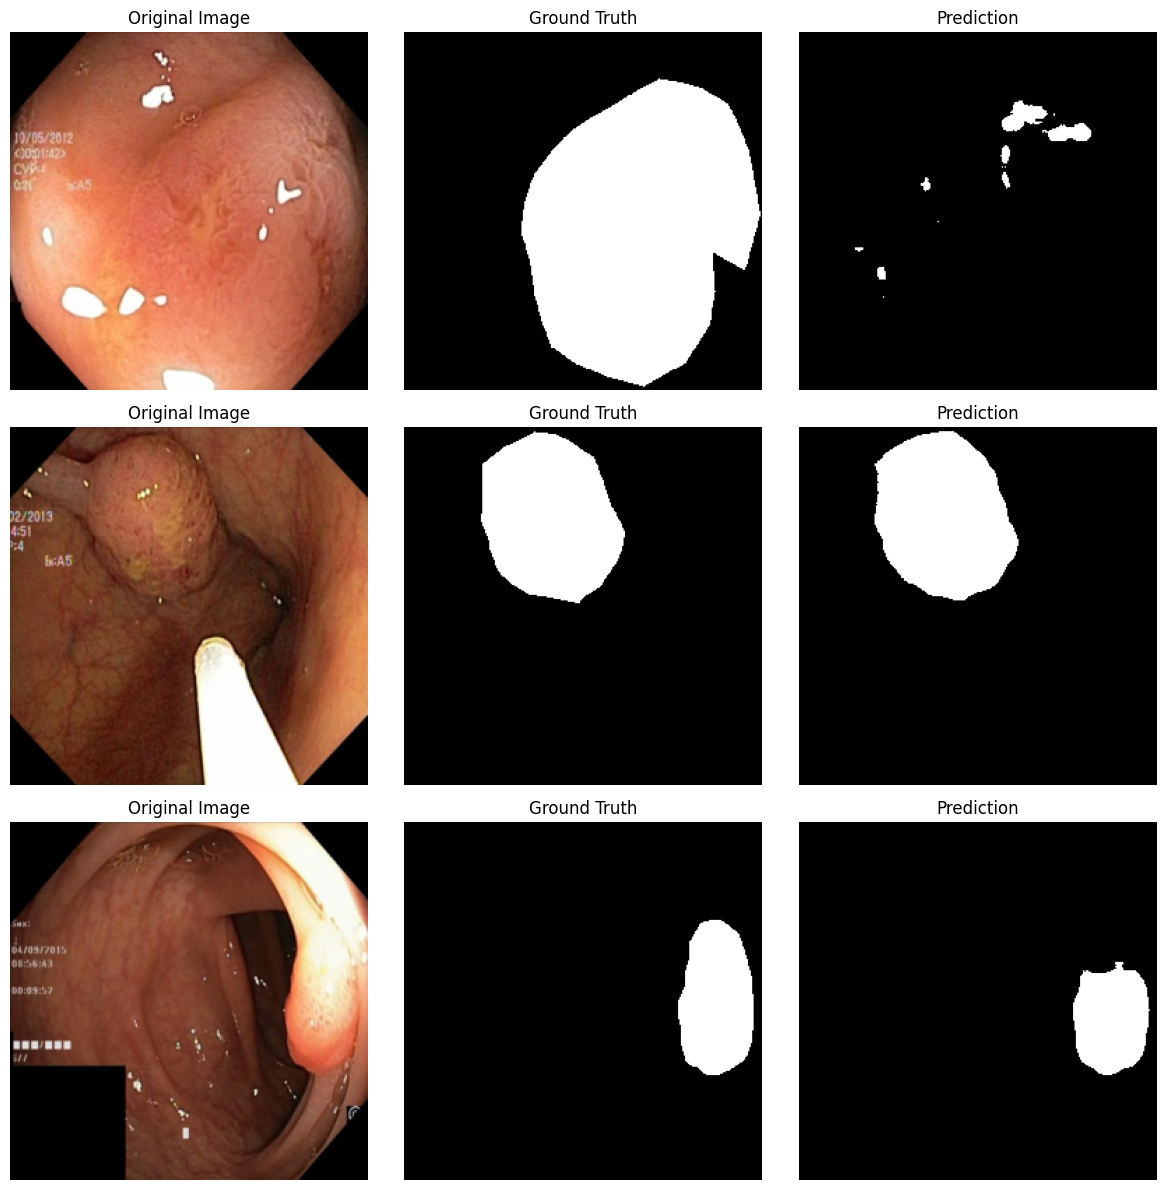

Training and evaluation completed!


In [4]:
# -------------------------
# Main Function - Adapted for Kaggle
# -------------------------
def main():
    print("Starting Mamba-UNet with Multi-Kernel Positional Embedding...")

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Download and set up the dataset
    kvasir_path = download_and_setup_dataset(force_download=False)

    if not kvasir_path:
        print("Dataset setup failed. Exiting...")
        return

    # Define transformations
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transform = T.Compose([
        T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
        lambda x: (x > 0.5).long()
    ])

    # Create datasets and data loaders
    try:
        train_dataset = KvasirSEGDataset(
            kvasir_path,
            split='train',
            transform=transform,
            target_transform=target_transform,
            augment=True
        )

        val_dataset = KvasirSEGDataset(
            kvasir_path,
            split='val',
            transform=transform,
            target_transform=target_transform,
            augment=False
        )

        # Use batch size of 4 as requested
        train_loader = DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=False,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        print("Data loaders created successfully.")
    except Exception as e:
        print(f"Error creating datasets: {e}")
        import traceback
        traceback.print_exc()
        return

    # Initialize model args and create model with MKPE
    args = ModelArgs()
    model = MambaUNetWithMKPE(args).to(device)
    print("Mamba-UNet model created with Multi-Kernel Positional Embedding.")

    # Define enhanced loss function and optimizer
    criterion = DeepSupervisionLoss(main_weight=0.6, deep2_weight=0.2, deep3_weight=0.2)
    
    # Slightly different learning rate for MKPE model
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # Add learning rate scheduler with warm restarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double period after each restart
        eta_min=1e-6,
    )

    # Training loop
    num_epochs = 100
    best_iou = 0.0
    patience_counter = 0
    max_patience = 20  # Early stopping after 20 epochs without improvement

    history = {
        'train_loss': [], 'train_iou': [], 'train_dice': [],
        'val_loss': [], 'val_iou': [], 'val_dice': []
    }

    print(f"Starting training for {num_epochs} epochs...")

    try:
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # Train with enhanced functions
            train_loss, train_iou, train_dice = train_one_epoch_enhanced(
                model, train_loader, optimizer, criterion, device, scheduler
            )

            # Validate
            val_loss, val_iou, val_dice = validate_enhanced(
                model, val_loader, criterion, device
            )

            # Save history
            history['train_loss'].append(train_loss)
            history['train_iou'].append(train_iou)
            history['train_dice'].append(train_dice)
            history['val_loss'].append(val_loss)
            history['val_iou'].append(val_iou)
            history['val_dice'].append(val_dice)

            # Print epoch results
            print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")
            print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

            # Save best model
            if val_iou > best_iou:
                best_iou = val_iou
                torch.save(model.state_dict(), "/kaggle/working/best_mamba_unet_with_mkpe.pth")
                print(f"Model saved with IoU: {best_iou:.4f}")
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # Save checkpoint every 10 epochs for safety
            if (epoch+1) % 10 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_iou': best_iou,
                    'history': history,
                }, f"/kaggle/working/checkpoint_mkpe_epoch_{epoch+1}.pth")

                # Plot and save training progress
                plot_training_progress(history, epoch+1)

            # Early stopping
            if patience_counter >= max_patience:
                print(f"Early stopping after {max_patience} epochs without improvement")
                break

            # Clear GPU cache between epochs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

        # Save checkpoint on error
        torch.save({
            'epoch': epoch if 'epoch' in locals() else 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if 'scheduler' in locals() else None,
            'best_iou': best_iou if 'best_iou' in locals() else 0,
            'history': history,
        }, "/kaggle/working/error_checkpoint_mkpe.pth")

    # Load best model for evaluation
    try:
        model.load_state_dict(torch.load("/kaggle/working/best_mamba_unet_with_mkpe.pth"))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")

    # Visualize results
    visualize_results(model, val_loader, device)

    print("Training and evaluation completed!")

if __name__ == "__main__":
    main()